In [1]:
import os
from pathlib import Path
import h5py
import pandas as pd
import numpy as np
import arpespythontools as arp
import matplotlib.pyplot as plt
from ipywidgets import widgets, Layout, interactive_output
import astropy 
from mpl_toolkits.mplot3d import Axes3D
import pickle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from datetime import datetime
import csv
# Run the notebook script
%run data_loader.ipynb

map_data2 = map_data2
phi = phi
energy = energy
theta = theta
theta_v = theta_v


Loaded data from cache: 20230317_00029_cache.pkl


# Replace Angle to Wavevector Block in other codes to these two blocks below. This will give you a GUI to change the zero point

In [2]:
def angle_to_wavevector_binding(E_pho, work_f, theta, phi):
    #CONVERTS PIXELS TO THETA
    global theta_v
    
    #print(theta_v)
    E_k = E_pho - work_f
    k = 0.512*np.sqrt(E_k)
    theta_rad = np.radians(theta_v)
    phi_rad = np.radians(phi)
    
    #K_x and K_Y 
    k_y = k*np.sin(theta_rad) #swapped from previous
    k_x = k*np.sin(phi_rad) #swapped from previous
    
    #k_x = np.degrees(k_x)
    #k_y = np.degrees(k_y)
    return k_x, k_y
        
    
global k_x_before_zeropoint
global k_y_before_zeropoint

k_x_before_zeropoint, k_y_before_zeropoint = angle_to_wavevector_binding(85, 4, theta_v, phi)

global emin1, emax2, vmax1, k_x1, k_x2, vmax2, pmin, pmax, vmax, k_y1, k_y2
emin1, emax2, vmax1 = -0.44, -0.41, 16226
k_x1, k_x2, vmax2 = -1, 360, 50000
k_y1, k_y2 = 0, 121
pmin, pmax, vmax = -1, 2, 35480


global k_x , k_y

zero_kx = None
zero_ky = None

def plt_plot(Vmax=16000, Emin=-0.44, Emax=-0.41,
             x1=None, x2=None, y1=None, y2=None,
             kx_dot=0, ky_dot=0):
    
    global surface1

    surface1 = arp.plane_slice(map_data2, energy, Emin, Emax)

    plt.figure(figsize=(8, 6))
    plt.imshow(surface1, aspect="auto", vmax=Vmax, origin='lower',
               extent=[k_x_before_zeropoint[0], k_x_before_zeropoint[-1], k_y_before_zeropoint[0], k_y_before_zeropoint[-1]], cmap='gray')
    plt.colorbar()
    plt.xlabel("Wavevector (k_x)")
    plt.ylabel("Wavevector (k_y)")
    plt.xlim(x1, x2)
    plt.ylim(y1, y2)
    plt.plot(kx_dot, ky_dot, 'ro', markersize=8)
    plt.show()

# Button callback
def save_zero_point(_):
    global zero_kx, zero_ky
    zero_kx = kx_dot_slider.value
    zero_ky = ky_dot_slider.value
    print(f"Zero point saved: kx = {zero_kx:.3f}, ky = {zero_ky:.3f}")

Vmax_slider = widgets.FloatSlider(value=16000, min=0, max=100000, step=100, description='Vmax')
Emin_slider = widgets.FloatSlider(value=-0.44, min=energy[0], max=energy[-1], step=0.01, description='Emin')
Emax_slider = widgets.FloatSlider(value=-0.41, min=energy[0], max=energy[-1], step=0.01, description='Emax')

x1_slider = widgets.FloatSlider(value=k_x_before_zeropoint[0], min=k_x_before_zeropoint[0], max=k_x_before_zeropoint[-1], step=0.01, description='x1')
x2_slider = widgets.FloatSlider(value=k_x_before_zeropoint[-1], min=k_x_before_zeropoint[0], max=k_x_before_zeropoint[-1], step=0.01, description='x2')
y1_slider = widgets.FloatSlider(value=k_y_before_zeropoint[0], min=k_y_before_zeropoint[0], max=k_y_before_zeropoint[-1], step=0.01, description='y1')
y2_slider = widgets.FloatSlider(value=k_y_before_zeropoint[-1], min=k_y_before_zeropoint[0], max=k_y_before_zeropoint[-1], step=0.01, description='y2')

kx_dot_slider = widgets.FloatSlider(value=0, min=k_x_before_zeropoint[0], max=k_x_before_zeropoint[-1], step=0.01, description='kx dot')
ky_dot_slider = widgets.FloatSlider(value=0, min=k_y_before_zeropoint[0], max=k_y_before_zeropoint[-1], step=0.01, description='ky dot')

zero_button = widgets.Button(description="Zero point", button_style='danger')
zero_button.on_click(save_zero_point)

ui = widgets.VBox([
    widgets.HBox([Vmax_slider, Emin_slider, Emax_slider]),
    widgets.HBox([x1_slider, x2_slider, y1_slider, y2_slider]),
    widgets.HBox([kx_dot_slider, ky_dot_slider, zero_button])
])

out = widgets.interactive_output(plt_plot, {
    'Vmax': Vmax_slider,
    'Emin': Emin_slider,
    'Emax': Emax_slider,
    'x1': x1_slider,
    'x2': x2_slider,
    'y1': y1_slider,
    'y2': y2_slider,
    'kx_dot': kx_dot_slider,
    'ky_dot': ky_dot_slider,
})

display(ui, out)



Output()

## Look from here

In [3]:
k_x = k_x_before_zeropoint - zero_kx
k_y = k_y_before_zeropoint - zero_ky

Text(0, 0.5, 'Energy Ev')

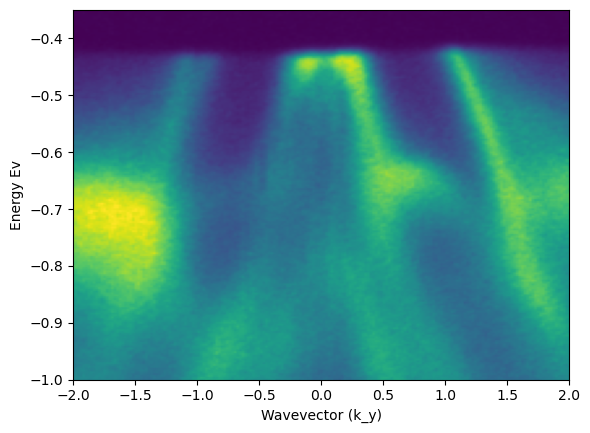

In [4]:
surface_EK = arp.plane_slice(map_data2.transpose([2, 0, 1]), k_x, -0.15, 0.15)


plt.imshow(surface_EK, aspect="auto", vmax=30000, origin='lower',
               extent=[k_y[0], k_y[-1], energy[0], energy[-1]], cmap='viridis')
plt.xlim(-2,2)
plt.ylim(-1,-0.35)
plt.xlabel("Wavevector (k_y)")
plt.ylabel("Energy Ev")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, report_fit
from scipy.ndimage import gaussian_filter1d
import ipywidgets as widgets

# Constants
k_B_eV = 8.617e-5   
T_fixed = 6.0       
kT_fixed = k_B_eV * T_fixed  
sigma_fixed_value = 0.010    # Fixed sigma in eV (10 meV)

# --- Model Components ---
def fermi_dirac(x, mu, kT):
    return 1.0 / (np.exp((x - mu) / kT) + 1.0)

def lorentzian_peak(x, A_qp, E_qp, gamma_qp):
    return (A_qp * (gamma_qp**2)) / ((x - E_qp)**2 + (gamma_qp**2))

def convolve_with_gaussian(y, x, sigma):
    if sigma <= 0:
        return y.copy()
    dx = x[1] - x[0]
    if dx == 0:
        return y.copy()
    sigma_samples = sigma / dx
    return gaussian_filter1d(y, sigma=sigma_samples, mode='nearest')

def model_convolved(x, mu, kT, A_fd, B, include_qp, A_qp, E_qp, gamma_qp, sigma):
    fd = A_fd * fermi_dirac(x, mu, kT)
    qp = lorentzian_peak(x, A_qp, E_qp, gamma_qp) if include_qp else 0.0
    raw = fd + qp + B
    return convolve_with_gaussian(raw, x, sigma)

# --- Fitting ---
def residuals(params, x, y):
    mu         = params['mu'].value
    kT         = params['kT'].value
    A_fd       = params['A_fd'].value
    B          = params['B'].value
    include_qp = bool(params['include_qp'].value)
    A_qp       = params['A_qp'].value
    E_qp       = params['E_qp'].value
    gamma_qp   = params['gamma_qp'].value
    sigma      = params['sigma'].value

    y_model = model_convolved(x, mu, kT, A_fd, B, include_qp, A_qp, E_qp, gamma_qp, sigma)
    return y_model - y

def fit_edc(x, y, include_qp=True):
    B0 = np.min(y)
    A0 = max(1.0, np.max(y) - B0)
    half = B0 + 0.5 * A0
    mu0 = x[np.argmin(np.abs(y - half))] if len(x) > 5 else np.median(x)
    Eqp0 = x[np.argmax(y)]
    Aqp0 = max(0.0, np.max(y) - (B0 + 0.9*A0))
    gam0 = max((x[1]-x[0]) * 3.0, 1e-4)

    p = Parameters()
    p.add('mu', value=-0.44, min=np.min(x), max=np.max(x), vary=True)
    p.add('kT', value=kT_fixed, vary=False)  # Fixed at 6 K
    p.add('A_fd', value=A0, min=0, vary=True)
    p.add('B', value=B0, vary=True)
    p.add('include_qp', value=int(include_qp), vary=False)
    p.add('A_qp', value=Aqp0, min=0, vary=include_qp)
    p.add('E_qp', value=-.40, min=np.min(x), max=np.max(x), vary=include_qp)
    p.add('gamma_qp', value=gam0, min=1e-4, max=(np.max(x)-np.min(x))/2, vary=include_qp)
    p.add('sigma', value=sigma_fixed_value, vary=False)  # Fixed sigma (10 meV)

    result = minimize(residuals, p, args=(x, y))
    best = result.params

    y_fit = model_convolved(
        x,
        best['mu'].value, best['kT'].value, best['A_fd'].value, best['B'].value,
        bool(best['include_qp'].value), best['A_qp'].value, best['E_qp'].value, best['gamma_qp'].value,
        best['sigma'].value
    )

    fit_params = {k: best[k].value for k in best.keys()}
    return y_fit, fit_params, result

def plot1d_with_controls(k_x1=-.22, k_x2=.19,
                         x_min=-0.52, x_max=-0.36,
                         y_min=0,
                         do_fit=True,
                         include_qp=True):
    
   
    k_y1 = -0.05
    k_y2 =  0.05
    surfaceE = arp.plane_slice(map_data2.transpose([1, 0, 2]), k_y, k_y1, k_y2)
    energy_lineE = arp.line_profile(surfaceE, k_x, k_x1, k_x2)

    mask = (energy >= x_min) & (energy <= x_max)
    x = energy[mask]
    y = energy_lineE[mask]

    # Automatically scale y-axis: 1.2 × max(y)
    y_max = 1.2 * np.max(y)

    # Plot data
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=24, color='black', label='Data', zorder=3)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Intensity')
    plt.title(f"EDC, kx = [{k_x1:.2f}, {k_x2:.2f}]")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    if do_fit and len(x) > 10:
        y_fit, fit_params, result = fit_edc(x, y, include_qp=include_qp)
        plt.plot(x, y_fit, 'r-', lw=2, label='Model Fit', zorder=2)
        plt.legend()
        plt.show()

        # Residual plot
        resid = y - y_fit
        plt.figure(figsize=(6,2))
        plt.scatter(x, resid, s=20, color='black')
        plt.axhline(0, ls='--', color='red')
        plt.xlabel('Energy (eV)')
        plt.ylabel('Residual')
        plt.xlim(x_min, x_max)
        plt.title('Fit Residuals')
        plt.show()

        report_fit(result)
    else:
        plt.legend()
        plt.show()


widgets.interact(
    plot1d_with_controls,
    k_x1=(k_x[0], k_x[-1], 0.01),
    k_x2=(k_x[0], k_x[-1], 0.01),
    x_min=(energy[0], energy[-1], 0.01),
    x_max=(energy[0], energy[-1], 0.01),
    y_min=(0, 50000, 100),
    do_fit=True,
    include_qp=True
)


interactive(children=(FloatSlider(value=-0.22, description='k_x1', max=1.4852763196648313, min=-0.899999999999…

<function __main__.plot1d_with_controls(k_x1=-0.22, k_x2=0.19, x_min=-0.52, x_max=-0.36, y_min=0, do_fit=True, include_qp=True)>

# Batch Fit

In [6]:
kx_start, kx_end = -0.10, 0.0      # total Kx range
slice_width = 0.05                  # width of each slice
step = 0.02                         # step between slice centers
ky1, ky2 = -0.05, 0.05
E_window = (-0.52, -0.36)

results = []

for kx1 in np.arange(kx_start, kx_end - slice_width + step, step):
    kx2 = kx1 + slice_width
    kx_center = 0.5 * (kx1 + kx2)

    surfaceE = arp.plane_slice(map_data2.transpose([1, 0, 2]), k_y, ky1, ky2)
    EDC = arp.line_profile(surfaceE, k_x, kx1, kx2)

    mask = (energy >= E_window[0]) & (energy <= E_window[1])
    x = energy[mask]
    y = EDC[mask]

    if len(x) < 10:
        continue

    y_fit, fit_params, result = fit_edc(x, y, include_qp=True)
    p = result.params

    results.append({
        "kx": kx_center,
        "mu": p["mu"].value,
        "Eqp": p["E_qp"].value,
        "mu_err": p["mu"].stderr if p["mu"].stderr else np.nan,
        "Eqp_err": p["E_qp"].stderr if p["E_qp"].stderr else np.nan
    })

print(f"Fitted {len(results)} slices.")


Fitted 4 slices.


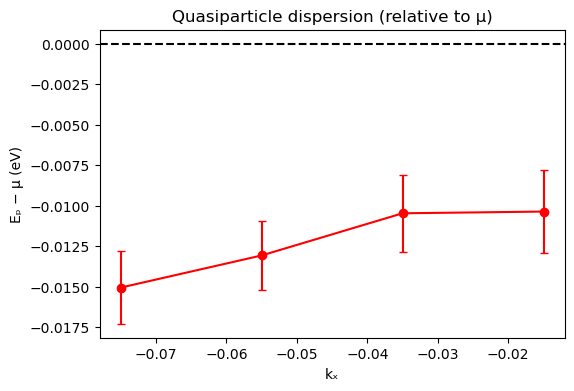

In [7]:
kx_vals = np.array([r["kx"] for r in results])
Eqp_rel = np.array([r["Eqp"] - r["mu"] for r in results])
Eqp_err = np.array([r["Eqp_err"] for r in results])

plt.figure(figsize=(6,4))
plt.errorbar(kx_vals, Eqp_rel, yerr=Eqp_err, fmt='o-', color='red', capsize=3)
plt.axhline(0, color='black', ls='--')
plt.xlabel("kₓ")
plt.ylabel("Eₚ − μ (eV)")
plt.title("Quasiparticle dispersion (relative to μ)")
plt.show()

# EDC Ky

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, report_fit
from scipy.ndimage import gaussian_filter1d
import ipywidgets as widgets

# Constants
k_B_eV = 8.617e-5   
T_fixed = 6.0       
kT_fixed = k_B_eV * T_fixed  
sigma_fixed_value = 0.010    # Fixed sigma in eV (10 meV)

# --- Model Components ---
def fermi_dirac(x, mu, kT):
    return 1.0 / (np.exp((x - mu) / kT) + 1.0)

def lorentzian_peak(x, A_qp, E_qp, gamma_qp):
    return (A_qp * (gamma_qp**2)) / ((x - E_qp)**2 + (gamma_qp**2))

def convolve_with_gaussian(y, x, sigma):
    if sigma <= 0:
        return y.copy()
    dx = x[1] - x[0]
    if dx == 0:
        return y.copy()
    sigma_samples = sigma / dx
    return gaussian_filter1d(y, sigma=sigma_samples, mode='nearest')

def model_convolved(x, mu, kT, A_fd, B, include_qp, A_qp, E_qp, gamma_qp, sigma):
    fd = A_fd * fermi_dirac(x, mu, kT)
    qp = lorentzian_peak(x, A_qp, E_qp, gamma_qp) if include_qp else 0.0
    raw = fd + qp + B
    return convolve_with_gaussian(raw, x, sigma)


def residuals(params, x, y):
    mu         = params['mu'].value
    kT         = params['kT'].value
    A_fd       = params['A_fd'].value
    B          = params['B'].value
    include_qp = bool(params['include_qp'].value)
    A_qp       = params['A_qp'].value
    E_qp       = params['E_qp'].value
    gamma_qp   = params['gamma_qp'].value
    sigma      = params['sigma'].value

    y_model = model_convolved(x, mu, kT, A_fd, B, include_qp, A_qp, E_qp, gamma_qp, sigma)
    return y_model - y

def fit_edc(x, y, include_qp=True):
    B0 = np.min(y)
    A0 = max(1.0, np.max(y) - B0)
    half = B0 + 0.5 * A0
    mu0 = x[np.argmin(np.abs(y - half))] if len(x) > 5 else np.median(x)
    Eqp0 = x[np.argmax(y)]
    Aqp0 = max(0.0, np.max(y) - (B0 + 0.9*A0))
    gam0 = max((x[1]-x[0]) * 3.0, 1e-4)

    p = Parameters()
    p.add('mu', value=-0.44, min=np.min(x), max=np.max(x), vary=True)
    p.add('kT', value=kT_fixed, vary=False)
    p.add('A_fd', value=A0, min=0, vary=True)
    p.add('B', value=B0, vary=True)
    p.add('include_qp', value=int(include_qp), vary=False)
    p.add('A_qp', value=Aqp0, min=0, vary=include_qp)
    p.add('E_qp', value=-.40, min=np.min(x), max=np.max(x), vary=include_qp)
    p.add('gamma_qp', value=gam0, min=1e-4, max=(np.max(x)-np.min(x))/2, vary=include_qp)
    p.add('sigma', value=sigma_fixed_value, vary=False)

    result = minimize(residuals, p, args=(x, y))
    best = result.params

    y_fit = model_convolved(
        x,
        best['mu'].value, best['kT'].value, best['A_fd'].value, best['B'].value,
        bool(best['include_qp'].value), best['A_qp'].value, best['E_qp'].value,
        best['gamma_qp'].value, best['sigma'].value
    )

    fit_params = {k: best[k].value for k in best.keys()}
    return y_fit, fit_params, result


def plot1d_with_controls(k_y1=-0.1, k_y2=0.1,
                         x_min=-0.52, x_max=-0.36,
                         y_min=0,
                         do_fit=True,
                         include_qp=True):

    kx1, kx2 = -0.05, 0.05  
    surfaceE = arp.plane_slice(map_data2.transpose([2, 0, 1]), k_x, kx1, kx2)
    energy_lineE = arp.line_profile(surfaceE, k_y, k_y1, k_y2)

    mask = (energy >= x_min) & (energy <= x_max)
    x = energy[mask]
    y = energy_lineE[mask]

    y_max = 1.2 * np.max(y)

    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=24, color='black', label='Data', zorder=3)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Intensity')
    plt.title(f"EDC, ky = [{k_y1:.2f}, {k_y2:.2f}]")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    if do_fit and len(x) > 10:
        y_fit, fit_params, result = fit_edc(x, y, include_qp=include_qp)
        plt.plot(x, y_fit, 'r-', lw=2, label='Model Fit', zorder=2)
        plt.legend()
        plt.show()

        resid = y - y_fit
        plt.figure(figsize=(6,2))
        plt.scatter(x, resid, s=20, color='black')
        plt.axhline(0, ls='--', color='red')
        plt.xlabel('Energy (eV)')
        plt.ylabel('Residual')
        plt.xlim(x_min, x_max)
        plt.title('Fit Residuals')
        plt.show()

        report_fit(result)
    else:
        plt.legend()
        plt.show()


widgets.interact(
    plot1d_with_controls,
    k_y1=(k_y[0], k_y[-1], 0.01),
    k_y2=(k_y[0], k_y[-1], 0.01),
    x_min=(energy[0], energy[-1], 0.01),
    x_max=(energy[0], energy[-1], 0.01),
    y_min=(0, 50000, 100),
    do_fit=True,
    include_qp=True
)


interactive(children=(FloatSlider(value=-0.1, description='k_y1', max=4.276248983156915, min=-4.72, step=0.01)…

<function __main__.plot1d_with_controls(k_y1=-0.1, k_y2=0.1, x_min=-0.52, x_max=-0.36, y_min=0, do_fit=True, include_qp=True)>

Text(0, 0.5, 'Energy Ev')

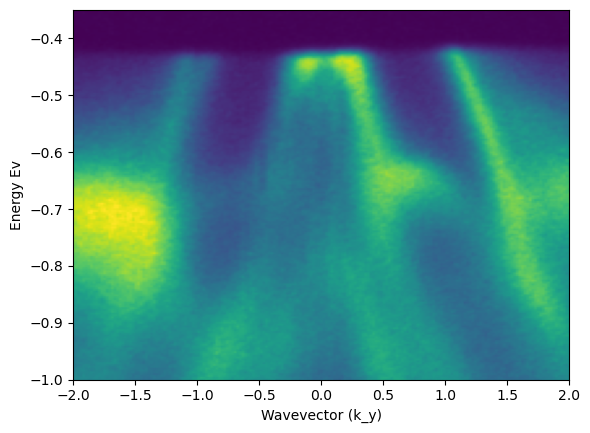

In [9]:
surfaceky_EK = arp.plane_slice(map_data2.transpose([2, 0, 1]), k_x, -0.15, 0.15)


plt.imshow(surface_EK, aspect="auto", vmax=30000, origin='lower',
               extent=[k_y[0], k_y[-1], energy[0], energy[-1]], cmap='viridis')
plt.xlim(-2,2)
plt.ylim(-1,-0.35)
plt.xlabel("Wavevector (k_y)")
plt.ylabel("Energy Ev")

In [10]:
surfaceky_EK.shape

(608, 428)

In [11]:
def align_fermi_for_ky_range(map_data2, k_x, k_y, energy,
                             ky_window=(-0.3, 0.3),
                             kx_window=(-0.05, 0.05),
                             E_fit_range=(-0.52, -0.36),
                             include_qp=True):
 

    ky1, ky2 = ky_window
    kx1, kx2 = kx_window
    Emin, Emax = E_fit_range


    surface_EK = arp.plane_slice(map_data2.transpose([2, 0, 1]), k_x, kx1, kx2)

    ky_mask = (k_y >= ky1) & (k_y <= ky2)
    ky_sub = k_y[ky_mask]
    sub_EK = surface_EK[:, ky_mask]
    nE, nKy = sub_EK.shape

    if np.any(np.diff(energy) < 0):
        order = np.argsort(energy)
        energy = energy[order]
        sub_EK = sub_EK[order, :]

    mu_by_ky = np.full(nKy, np.nan)
    for j in range(nKy):
        I_col = sub_EK[:, j]
        mE = (energy >= Emin) & (energy <= Emax)
        x_fit, y_fit = energy[mE], I_col[mE]
        if np.nanmax(y_fit) <= 0:
            continue
        try:
            _, p, _ = fit_edc(x_fit, y_fit, include_qp=include_qp)
            mu_by_ky[j] = p["mu"]
        except Exception:
            mu_by_ky[j] = np.nan

    valid = ~np.isnan(mu_by_ky)
    dE = np.median(np.diff(energy))
    if np.any(valid):
        E_min_new = np.min(energy[0] - mu_by_ky[valid])
        E_max_new = np.max(energy[-1] - mu_by_ky[valid])
    else:
        E_min_new, E_max_new = energy[0], energy[-1]
    E_common = np.arange(E_min_new, E_max_new + dE, dE)

    aligned_sub = np.full((len(E_common), nKy), np.nan)
    for j in range(nKy):
        mu = mu_by_ky[j]
        if np.isnan(mu):
            continue
        shifted_E = energy - mu  
        aligned_sub[:, j] = np.interp(E_common, shifted_E, sub_EK[:, j],
                                      left=np.nan, right=np.nan)

    vmax_val = np.nanpercentile(sub_EK, 99.5)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(sub_EK, aspect="auto", origin="lower",
               extent=[ky_sub[0], ky_sub[-1], energy[0], energy[-1]],
               cmap="viridis", vmax=vmax_val)
    plt.xlabel(r"$k_y$")
    plt.ylabel("Energy (eV)")
    plt.title(f"Original  E vs $k_y$  ({ky1:.2f} → {ky2:.2f})")

    plt.subplot(1, 2, 2)
    plt.imshow(aligned_sub, aspect="auto", origin="lower",
               extent=[ky_sub[0], ky_sub[-1], E_common[0], E_common[-1]],
               cmap="viridis", vmax=7500)
    plt.xlabel(r"$k_y$")
    plt.ylabel("Energy aligned to $E_F$ (eV)")
    plt.title(r"Aligned:  $E \rightarrow E - \mu(k_y)$")
    plt.ylim(-.4, .4)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(ky_sub, mu_by_ky, "o-", lw=1.5)
    plt.xlabel(r"$k_y$")
    plt.ylabel(r"$\mu(k_y)$ (eV)")
    plt.title(f"Fitted $E_F$ vs $k_y$  ({ky1:.2f} → {ky2:.2f})")
    plt.grid(alpha=0.3)
    plt.show()

    return aligned_sub, mu_by_ky, ky_sub, E_common


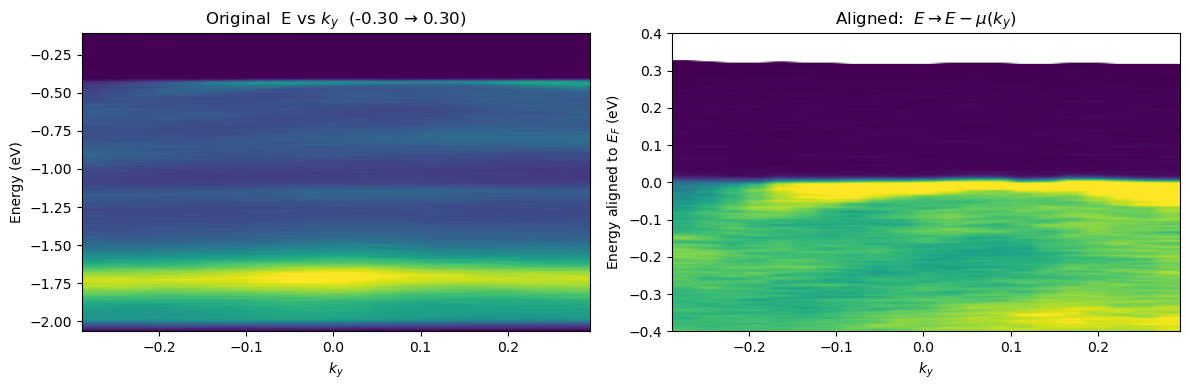

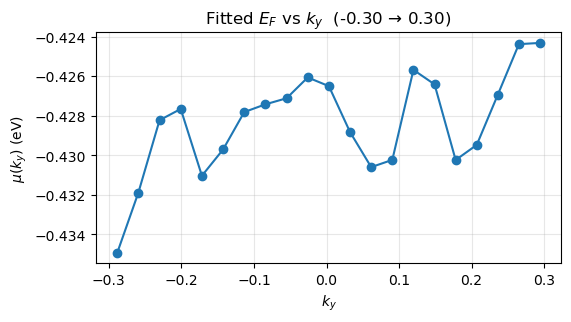

In [12]:

aligned_sub, mu_by_ky, ky_sub, E_range = align_fermi_for_ky_range(
    map_data2,
    k_x,
    k_y,
    energy,
    ky_window=(-.3, .3),    
    kx_window=(-0.05, 0.05),
    E_fit_range=(-0.52, -0.36),
    include_qp=True
)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

def align_fermi_for_ky_range(map_data2, k_x, k_y, energy,
                             ky_window=(-0.3, 0.3),
                             kx_window=(-0.05, 0.05),
                             E_fit_range=(-0.52, -0.36),
                             include_qp=True,
                             show_each_fit=True):

    ky1, ky2 = ky_window
    kx1, kx2 = kx_window
    Emin, Emax = E_fit_range

    # --- Slice the map in ky range ---
    surface_EK = arp.plane_slice(map_data2.transpose([2, 0, 1]), k_x, kx1, kx2)
    ky_mask = (k_y >= ky1) & (k_y <= ky2)
    ky_sub = k_y[ky_mask]
    sub_EK = surface_EK[:, ky_mask]
    nE, nKy = sub_EK.shape

    
    if np.any(np.diff(energy) < 0):
        order = np.argsort(energy)
        energy = energy[order]
        sub_EK = sub_EK[order, :]

    mu_by_ky = np.full(nKy, np.nan)

    
    for j in range(nKy):
        I_col = sub_EK[:, j]
        mE = (energy >= Emin) & (energy <= Emax)
        x_fit, y_fit = energy[mE], I_col[mE]

        if np.nanmax(y_fit) <= 0:
            continue

        try:
            y_model, p, result = fit_edc(x_fit, y_fit, include_qp=include_qp)
            # handle both lmfit.Parameter and float
            mu_val = p["mu"].value if hasattr(p["mu"], "value") else float(p["mu"])
            mu_by_ky[j] = mu_val

            
            def get_err_percent(param):
                
                if hasattr(p[param], "value"):
                    val = p[param].value
                else:
                    val = p[param]

                # try stderr from p or result.params
                if hasattr(p[param], "stderr") and p[param].stderr is not None:
                    err = p[param].stderr
                elif hasattr(result, "params") and param in result.params and hasattr(result.params[param], "stderr"):
                    err = result.params[param].stderr
                else:
                    err = None

                if err is None or val == 0:
                    return np.nan
                return abs(err / val) * 100.0

            mu_err = get_err_percent("mu")
            eqp_err = get_err_percent("E_qp")
            gamma_err = get_err_percent("gamma_qp")

            
            if show_each_fit:
                plt.figure(figsize=(5.5, 3.8))
                plt.plot(x_fit, y_fit, "k.", label="Data", markersize=4)
                plt.plot(x_fit, y_model, "r-", lw=2, label="Fit")
                plt.xlabel("Energy (eV)")
                plt.ylabel("Intensity (a.u.)")
                plt.title(f"ky = {ky_sub[j]:.3f}, μ = {mu_val:.3f} eV", fontsize=10)
                plt.legend()
                plt.grid(alpha=0.3)

                
                text = (f"μ err: {mu_err:.2f}%   "
                        f"E_qp err: {eqp_err:.2f}%   "
                        f"γ_qp err: {gamma_err:.2f}%")
                plt.figtext(0.15, 0.02, text, fontsize=9, ha="left", color="blue")

                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"Fit failed for ky={ky_sub[j]:+.3f}: {e}")
            mu_by_ky[j] = np.nan

    
    valid = ~np.isnan(mu_by_ky)
    dE = np.median(np.diff(energy))
    if np.any(valid):
        E_min_new = np.min(energy[0] - mu_by_ky[valid])
        E_max_new = np.max(energy[-1] - mu_by_ky[valid])
    else:
        E_min_new, E_max_new = energy[0], energy[-1]

    E_common = np.arange(E_min_new, E_max_new + dE, dE)
    aligned_sub = np.full((len(E_common), nKy), np.nan)

    for j in range(nKy):
        mu = mu_by_ky[j]
        if np.isnan(mu):
            continue
        shifted_E = energy - mu
        aligned_sub[:, j] = np.interp(E_common, shifted_E, sub_EK[:, j],
                                      left=np.nan, right=np.nan)

    
    vmax_val = np.nanpercentile(sub_EK, 99.5)
    y_min_def, y_max_def = -0.4, 0.4

    @interact(
        vmax_orig=widgets.FloatSlider(value=vmax_val, min=500, max=vmax_val*2, step=500, description="Orig vmax"),
        x_min_orig=widgets.FloatSlider(value=ky_sub[0], min=ky_sub[0], max=ky_sub[-1], step=0.02, description="Orig x min"),
        x_max_orig=widgets.FloatSlider(value=ky_sub[-1], min=ky_sub[0], max=ky_sub[-1], step=0.02, description="Orig x max"),
        y_min_orig=widgets.FloatSlider(value=energy[0], min=energy[0], max=energy[-1], step=0.02, description="Orig y min"),
        y_max_orig=widgets.FloatSlider(value=energy[-1], min=energy[0], max=energy[-1], step=0.02, description="Orig y max"),
        vmax_align=widgets.FloatSlider(value=vmax_val, min=500, max=vmax_val*2, step=500, description="Align vmax"),
        x_min_align=widgets.FloatSlider(value=ky_sub[0], min=ky_sub[0], max=ky_sub[-1], step=0.02, description="Align x min"),
        x_max_align=widgets.FloatSlider(value=ky_sub[-1], min=ky_sub[0], max=ky_sub[-1], step=0.02, description="Align x max"),
        y_min_align=widgets.FloatSlider(value=y_min_def, min=E_common[0], max=E_common[-1], step=0.02, description="Align y min"),
        y_max_align=widgets.FloatSlider(value=y_max_def, min=E_common[0], max=E_common[-1], step=0.02, description="Align y max")
    )
    def update(vmax_orig, x_min_orig, x_max_orig, y_min_orig, y_max_orig,
               vmax_align, x_min_align, x_max_align, y_min_align, y_max_align):

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(sub_EK, aspect="auto", origin="lower",
                   extent=[ky_sub[0], ky_sub[-1], energy[0], energy[-1]],
                   cmap="viridis", vmax=vmax_orig)
        plt.xlabel(r"$k_y$")
        plt.ylabel("Energy (eV)")
        plt.title("Original E–ky")
        plt.xlim(x_min_orig, x_max_orig)
        plt.ylim(y_min_orig, y_max_orig)

        plt.subplot(1, 2, 2)
        plt.imshow(aligned_sub, aspect="auto", origin="lower",
                   extent=[ky_sub[0], ky_sub[-1], E_common[0], E_common[-1]],
                   cmap="viridis", vmax=vmax_align)
        plt.xlabel(r"$k_y$")
        plt.ylabel("Energy aligned to $E_F$ (eV)")
        plt.title("Fermi-Edge Corrected Map")
        plt.xlim(x_min_align, x_max_align)
        plt.ylim(y_min_align, y_max_align)

        plt.tight_layout()
        plt.show()

    # --- μ(k_y) vs ky summary plot ---
    plt.figure(figsize=(6, 3))
    plt.plot(ky_sub, mu_by_ky, "o-", lw=1.5)
    plt.xlabel(r"$k_y$")
    plt.ylabel(r"$\mu(k_y)$ (eV)")
    plt.title(f"Fitted $E_F$ vs $k_y$ ({ky1:.2f} → {ky2:.2f})")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return aligned_sub, mu_by_ky, ky_sub, E_common



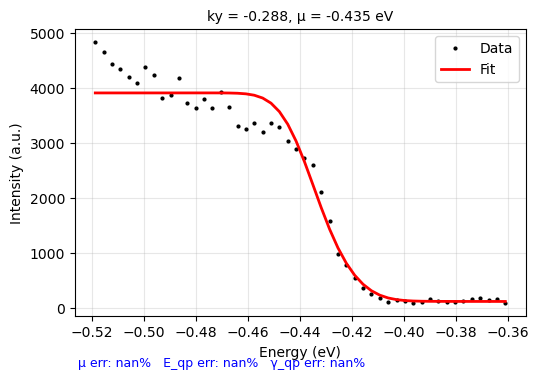

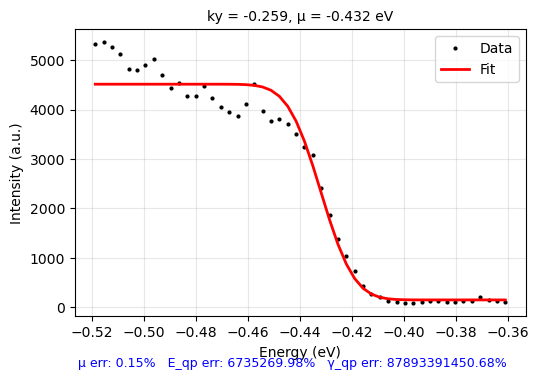

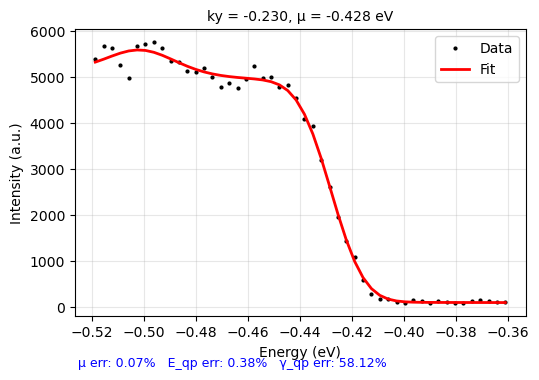

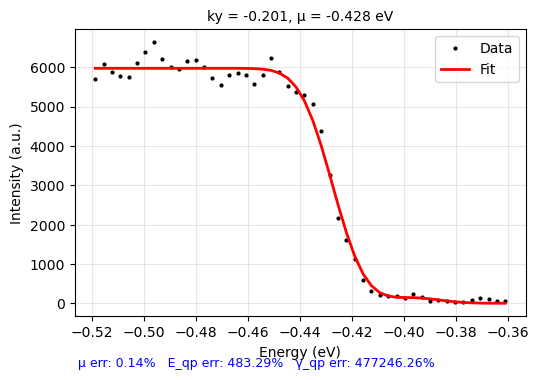

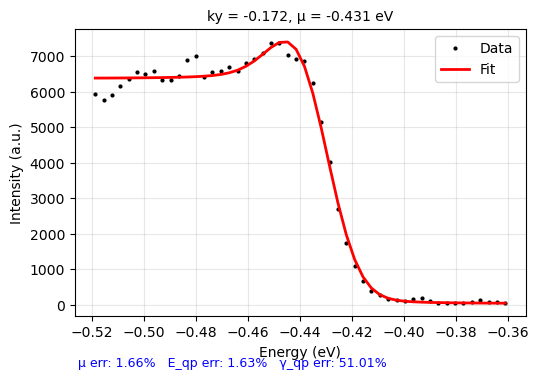

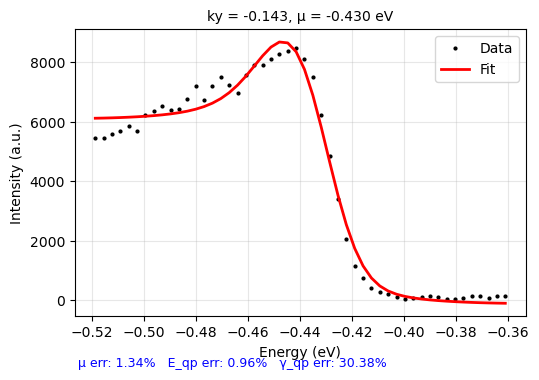

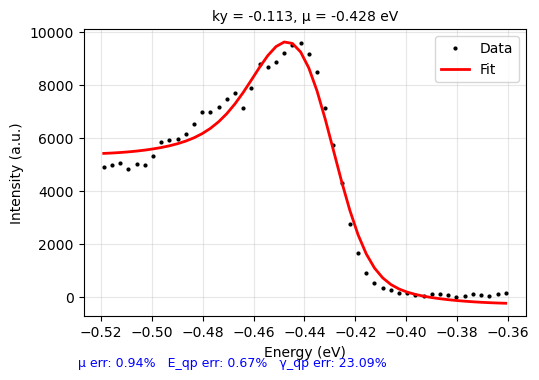

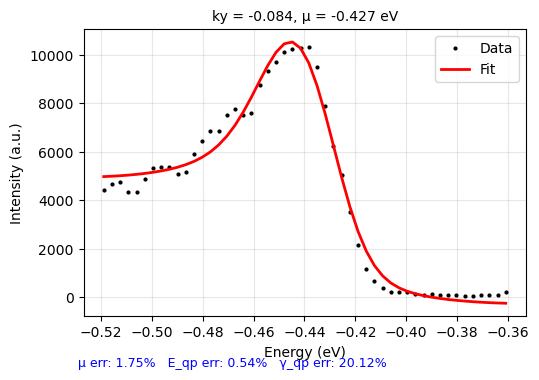

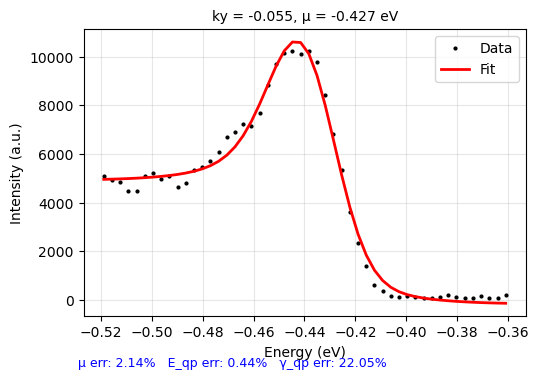

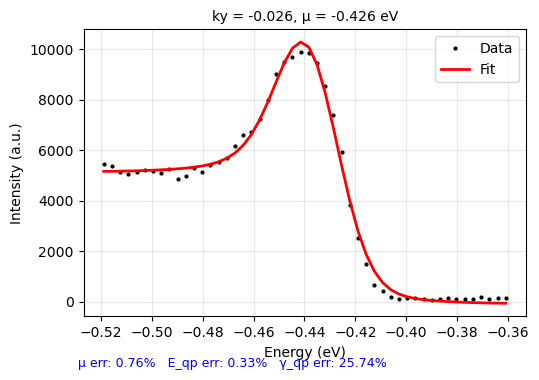

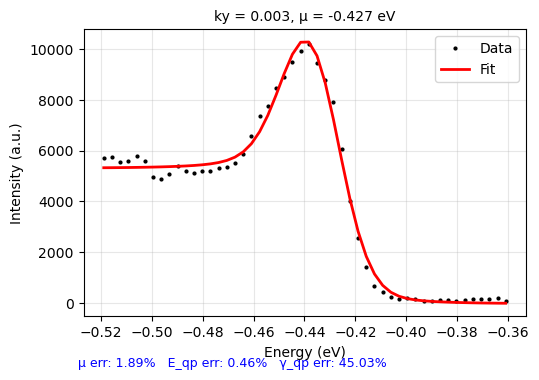

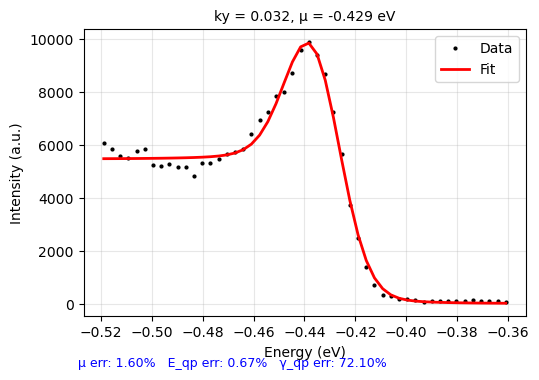

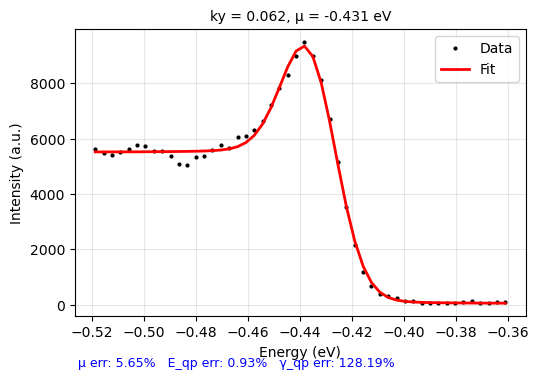

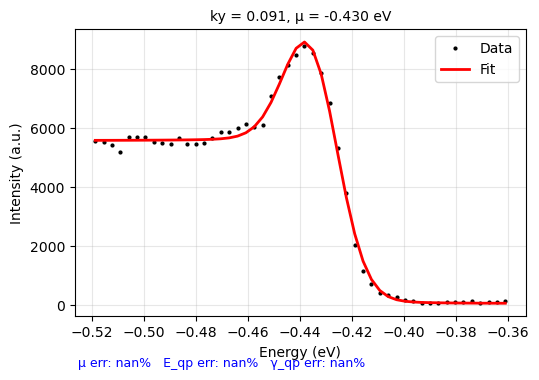

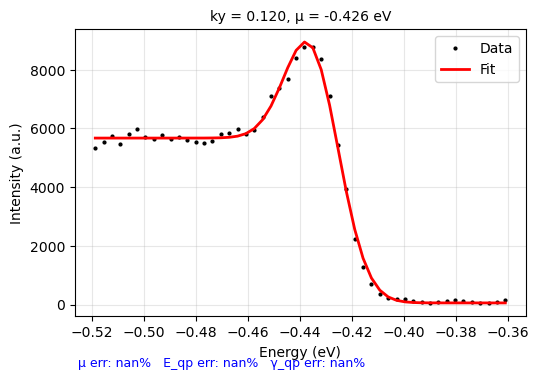

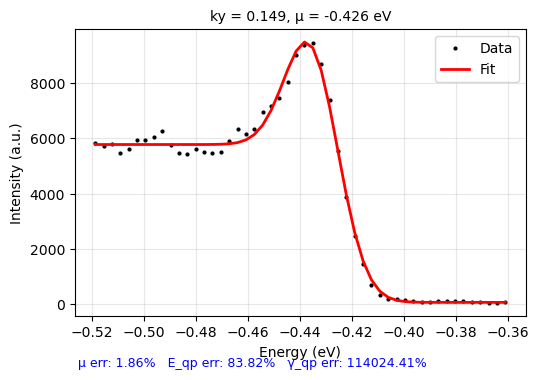

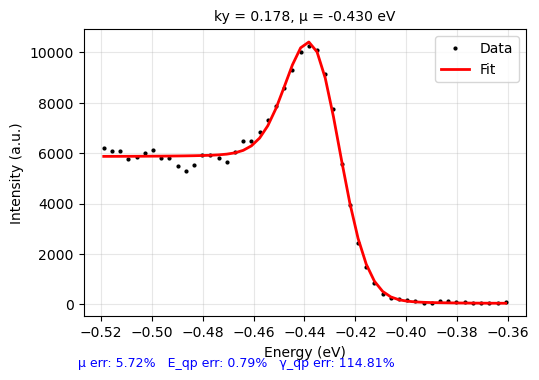

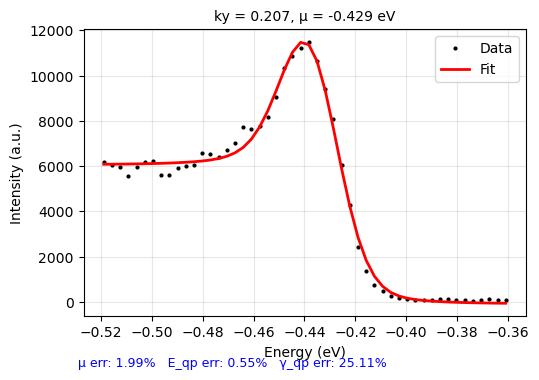

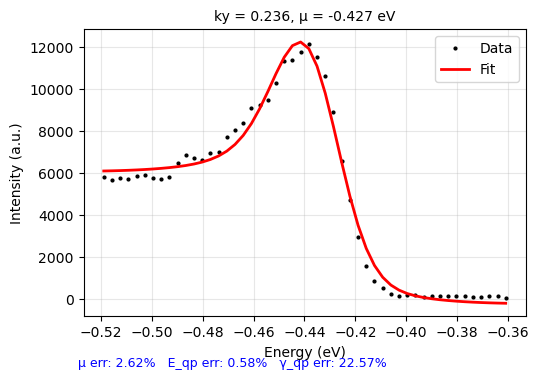

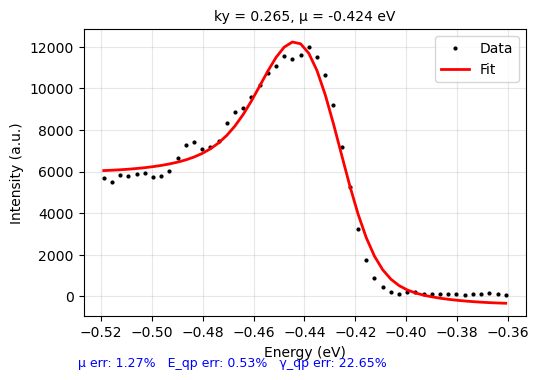

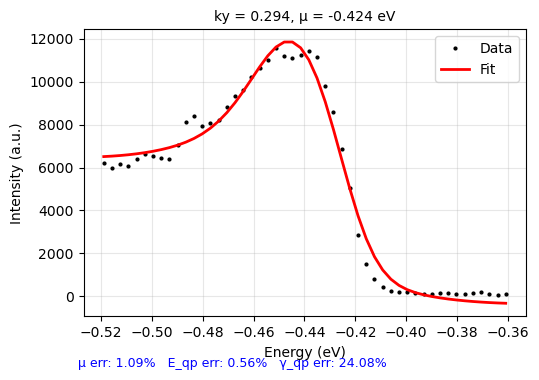

interactive(children=(FloatSlider(value=20278.42499999996, description='Orig vmax', max=40556.84999999992, min…

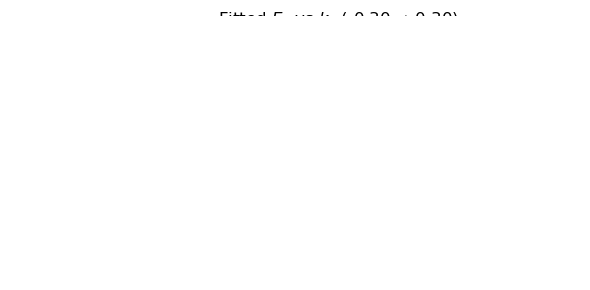

In [14]:
aligned_sub, mu_by_ky, ky_sub, E_common = align_fermi_for_ky_range(
    map_data2, k_x, k_y, energy,
    ky_window=(-0.3, 0.3),
    kx_window=(-0.05, 0.05),
    E_fit_range=(-0.52, -0.36),
    include_qp=True,
    show_each_fit=True   # turn off later for faster runs
)


# No interpolation

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def align_fermi_for_ky_range_true_shift(map_data2, k_x, k_y, energy,
                                        ky_window=(-0.3, 0.3),
                                        kx_window=(-0.05, 0.05),
                                        E_fit_range=(-0.52, -0.36),
                                        include_qp=True):

    ky1, ky2 = ky_window
    kx1, kx2 = kx_window
    Emin, Emax = E_fit_range

    surface_EK = arp.plane_slice(map_data2.transpose([2, 0, 1]), k_x, kx1, kx2)

    ky_mask = (k_y >= ky1) & (k_y <= ky2)
    ky_sub = k_y[ky_mask]
    sub_EK = surface_EK[:, ky_mask]
    nE, nKy = sub_EK.shape

    if np.any(np.diff(energy) < 0):
        order = np.argsort(energy)
        energy = energy[order]
        sub_EK = sub_EK[order, :]

    mu_by_ky = np.full(nKy, np.nan)
    for j in range(nKy):
        I_col = sub_EK[:, j]
        mask_E = (energy >= Emin) & (energy <= Emax)
        x_fit, y_fit = energy[mask_E], I_col[mask_E]
        if np.nanmax(y_fit) <= 0:
            continue
        try:
            _, params, _ = fit_edc(x_fit, y_fit, include_qp=include_qp)
            mu_by_ky[j] = params["mu"]
        except Exception:
            mu_by_ky[j] = np.nan

    # --- Step 2: Apply EF alignment (no interpolation) ---
    shifted_energy_grid = np.zeros_like(sub_EK)
    for j in range(nKy):
        mu = mu_by_ky[j]
        if np.isnan(mu):
            shifted_energy_grid[:, j] = np.nan
        else:
            shifted_energy_grid[:, j] = energy - mu

    Ky, E = np.meshgrid(ky_sub, energy)

    plt.figure(figsize=(12, 5))
    vmax_val = np.nanpercentile(sub_EK, 99.5)

    plt.subplot(1, 2, 1)
    plt.pcolormesh(Ky, E, sub_EK, shading='auto', cmap='viridis', vmin=0, vmax=vmax_val)
    plt.xlabel(r"$k_y$ ")
    plt.ylabel("Energy (eV)")
    plt.title(f"Original map: ky = {ky1:.2f} → {ky2:.2f}")
    plt.ylim(np.nanmin(energy), np.nanmax(energy))
    plt.colorbar(label="Intensity")

    plt.subplot(1, 2, 2)
    plt.pcolormesh(Ky, shifted_energy_grid, sub_EK, shading='auto', cmap='viridis', vmin=0, vmax=vmax_val)
    plt.xlabel(r"$k_y$")
    plt.ylabel("Energy aligned to $E_F$ (eV)")
    plt.title("Fermi-edge aligned (no interpolation)")
    plt.ylim(np.nanmin(shifted_energy_grid), np.nanmax(shifted_energy_grid))
    plt.colorbar(label="Intensity")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(ky_sub, mu_by_ky, 'o-', lw=1.5)
    plt.xlabel(r"$k_y$")
    plt.ylabel(r"$\mu(k_y)$ (eV)")
    plt.title(f"Fitted Fermi level vs ky ({ky1:.2f} → {ky2:.2f})")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return shifted_energy_grid, sub_EK, ky_sub, mu_by_ky


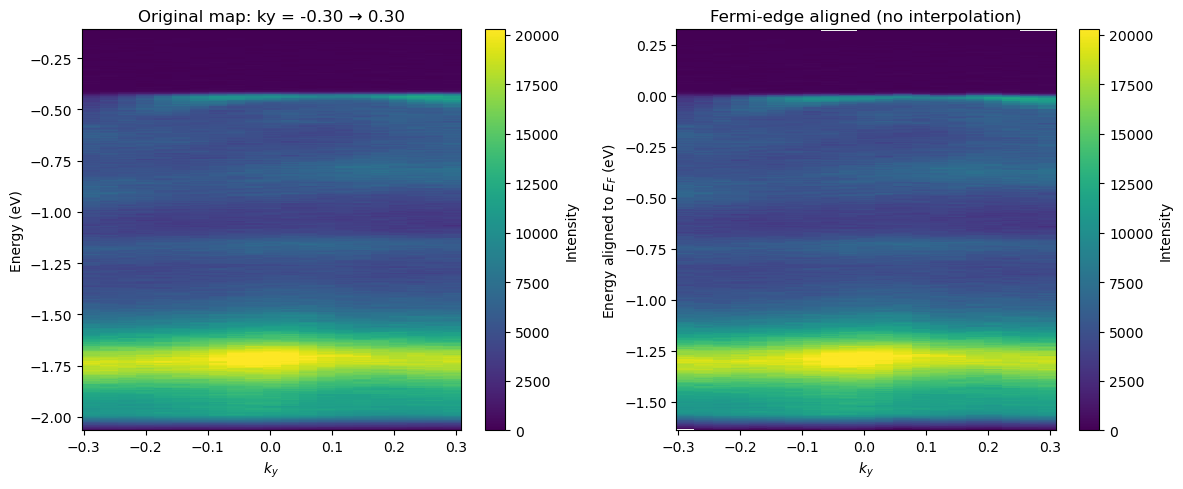

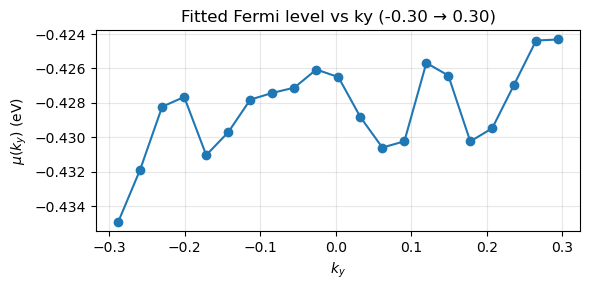

In [16]:
shifted_energy_grid, sub_EK, ky_sub, mu_by_ky = align_fermi_for_ky_range_true_shift(
    map_data2,
    k_x,
    k_y,
    energy,
    ky_window=(-0.3, 0.3),
    kx_window=(-0.05, 0.05),
    E_fit_range=(-0.52, -0.36),
    include_qp=True
)
